In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Load the dataset
file_path = "Baltimore_City_Employee_Salaries.csv"
data = pd.read_csv(file_path)

for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].str.lower()
# Display the schema
print("Dataset Schema:")
print(data.info())

# Display the first few rows for a quick overview
print("\nSample Data:")
print(data.head())

Dataset Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218647 entries, 0 to 218646
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            218647 non-null  int64  
 1   Name          218647 non-null  object 
 2   JobTitle      205721 non-null  object 
 3   AgencyID      209096 non-null  object 
 4   AgencyName    218606 non-null  object 
 5   HireDate      218328 non-null  object 
 6   AnnualSalary  218647 non-null  float64
 7   GrossPay      210168 non-null  float64
 8   FiscalYear    218647 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 15.0+ MB
None

Sample Data:
   ID                Name                       JobTitle AgencyID  \
0   1    aaron,patricia g  facilities/office services ii      a03   
1   2       aaron,petra l     assistant state's attorney      a29   
2   3  abaineh,yohannes t                 epidemiologist      a65   
3   4  abdal-rahim,naim a       

In [4]:
# Check for missing values
print("Missing Values Count:")
print(data.isnull().sum())

Missing Values Count:
ID                  0
Name                0
JobTitle        12926
AgencyID         9551
AgencyName         41
HireDate          319
AnnualSalary        0
GrossPay         8479
FiscalYear          0
dtype: int64


In [6]:
# Drop rows with missing values in AgencyName and HireDate
data = data.dropna(subset=['AgencyName', 'HireDate'])

# Calculate the overall mean for GrossPay
grosspay_mean = data['GrossPay'].mean()

# Fill remaining missing GrossPay values with the overall mean
data['GrossPay'].fillna(grosspay_mean, inplace=True)

# Drop rows with missing JobTitle and AgencyID
data = data.dropna(subset=['JobTitle', 'AgencyID'])

# Verify the cleaning process
print("Missing Values After Cleaning:")
print(data.isnull().sum())

print("\nCleaned Dataset Shape:", data.shape)


C:\Users\srive\AppData\Local\Temp\ipykernel_8092\1395790006.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['GrossPay'].fillna(grosspay_mean, inplace=True)


Missing Values After Cleaning:
ID              0
Name            0
JobTitle        0
AgencyID        0
AgencyName      0
HireDate        0
AnnualSalary    0
GrossPay        0
FiscalYear      0
dtype: int64

Cleaned Dataset Shape: (205394, 9)


In [7]:
# 1. Analysis of salary differences across agencies
# Calculate agency statistics
agency_stats = data.groupby('AgencyName').agg({
    'AnnualSalary': ['mean', 'std', 'count']
}).reset_index()
agency_stats.columns = ['AgencyName', 'MeanSalary', 'StdSalary', 'Count']

# Filter for agencies with more than 100 employees
significant_agencies = agency_stats[agency_stats['Count'] > 100].sort_values('MeanSalary', ascending=False)

# Perform one-way ANOVA on top 5 agencies
top_5_agencies = significant_agencies['AgencyName'].head().tolist()
salary_groups = [data[data['AgencyName'] == agency]['AnnualSalary'] for agency in top_5_agencies]
f_statistic, p_value = stats.f_oneway(*salary_groups)

print("\nAgency Salary Analysis:")
print(f"ANOVA test results: F-statistic = {f_statistic:.2f}, p-value = {p_value:.4f}")
print("\nTop 5 Agencies by Average Salary:")
print(significant_agencies[['AgencyName', 'MeanSalary', 'Count']].head())

# 2. Analysis of salary trends over time
# Calculate yearly averages
yearly_trends = data.groupby('FiscalYear').agg({
    'GrossPay': 'mean',
    'AnnualSalary': 'mean'
}).reset_index()

# Calculate year-over-year growth
yearly_trends['GrossPay_YoY'] = yearly_trends['GrossPay'].pct_change() * 100
yearly_trends['Salary_YoY'] = yearly_trends['AnnualSalary'].pct_change() * 100

# Perform linear regression on gross pay trend
years = pd.factorize(yearly_trends['FiscalYear'])[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(years, yearly_trends['GrossPay'])

print("\nSalary Trend Analysis:")
print(f"Linear regression results: Slope = {slope:.2f}, R² = {r_value**2:.4f}, p-value = {p_value:.4f}")
print("\nYearly Trends:")
print(yearly_trends)

# 3. Analysis of job titles and salaries
job_stats = data.groupby('JobTitle').agg({
    'AnnualSalary': ['mean', 'count']
}).reset_index()
job_stats.columns = ['JobTitle', 'MeanSalary', 'Count']

# Filter for common job titles (>50 employees)
common_jobs = job_stats[job_stats['Count'] > 50].sort_values('MeanSalary', ascending=False)
print("\nTop 10 Job Titles by Average Salary:")
print(common_jobs.head(10))


Agency Salary Analysis:
ANOVA test results: F-statistic = 3.64, p-value = 0.0059

Top 5 Agencies by Average Salary:
                                            AgencyName     MeanSalary  Count
279                              fire department (006)  105687.430328    244
267                 finance - administration & budgets   99435.255195    154
0    baltimore city office of information and techn...   97288.114816    353
494                                     law department   94860.958161    533
677                            police department (299)   91186.879630    108

Salary Trend Analysis:
Linear regression results: Slope = 2645.64, R² = 0.8977, p-value = 0.0000

Yearly Trends:
   FiscalYear      GrossPay  AnnualSalary  GrossPay_YoY  Salary_YoY
0      fy2011  42153.942718  45906.392204           NaN         NaN
1      fy2012  42960.579599  43254.935320      1.913550   -5.775790
2      fy2013  46005.698303  38209.130648      7.088170  -11.665269
3      fy2014  47110.930664  39660.

C:\Users\srive\AppData\Local\Temp\ipykernel_8092\341834517.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\srive\AppData\Local\Temp\ipykernel_8092\341834517.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


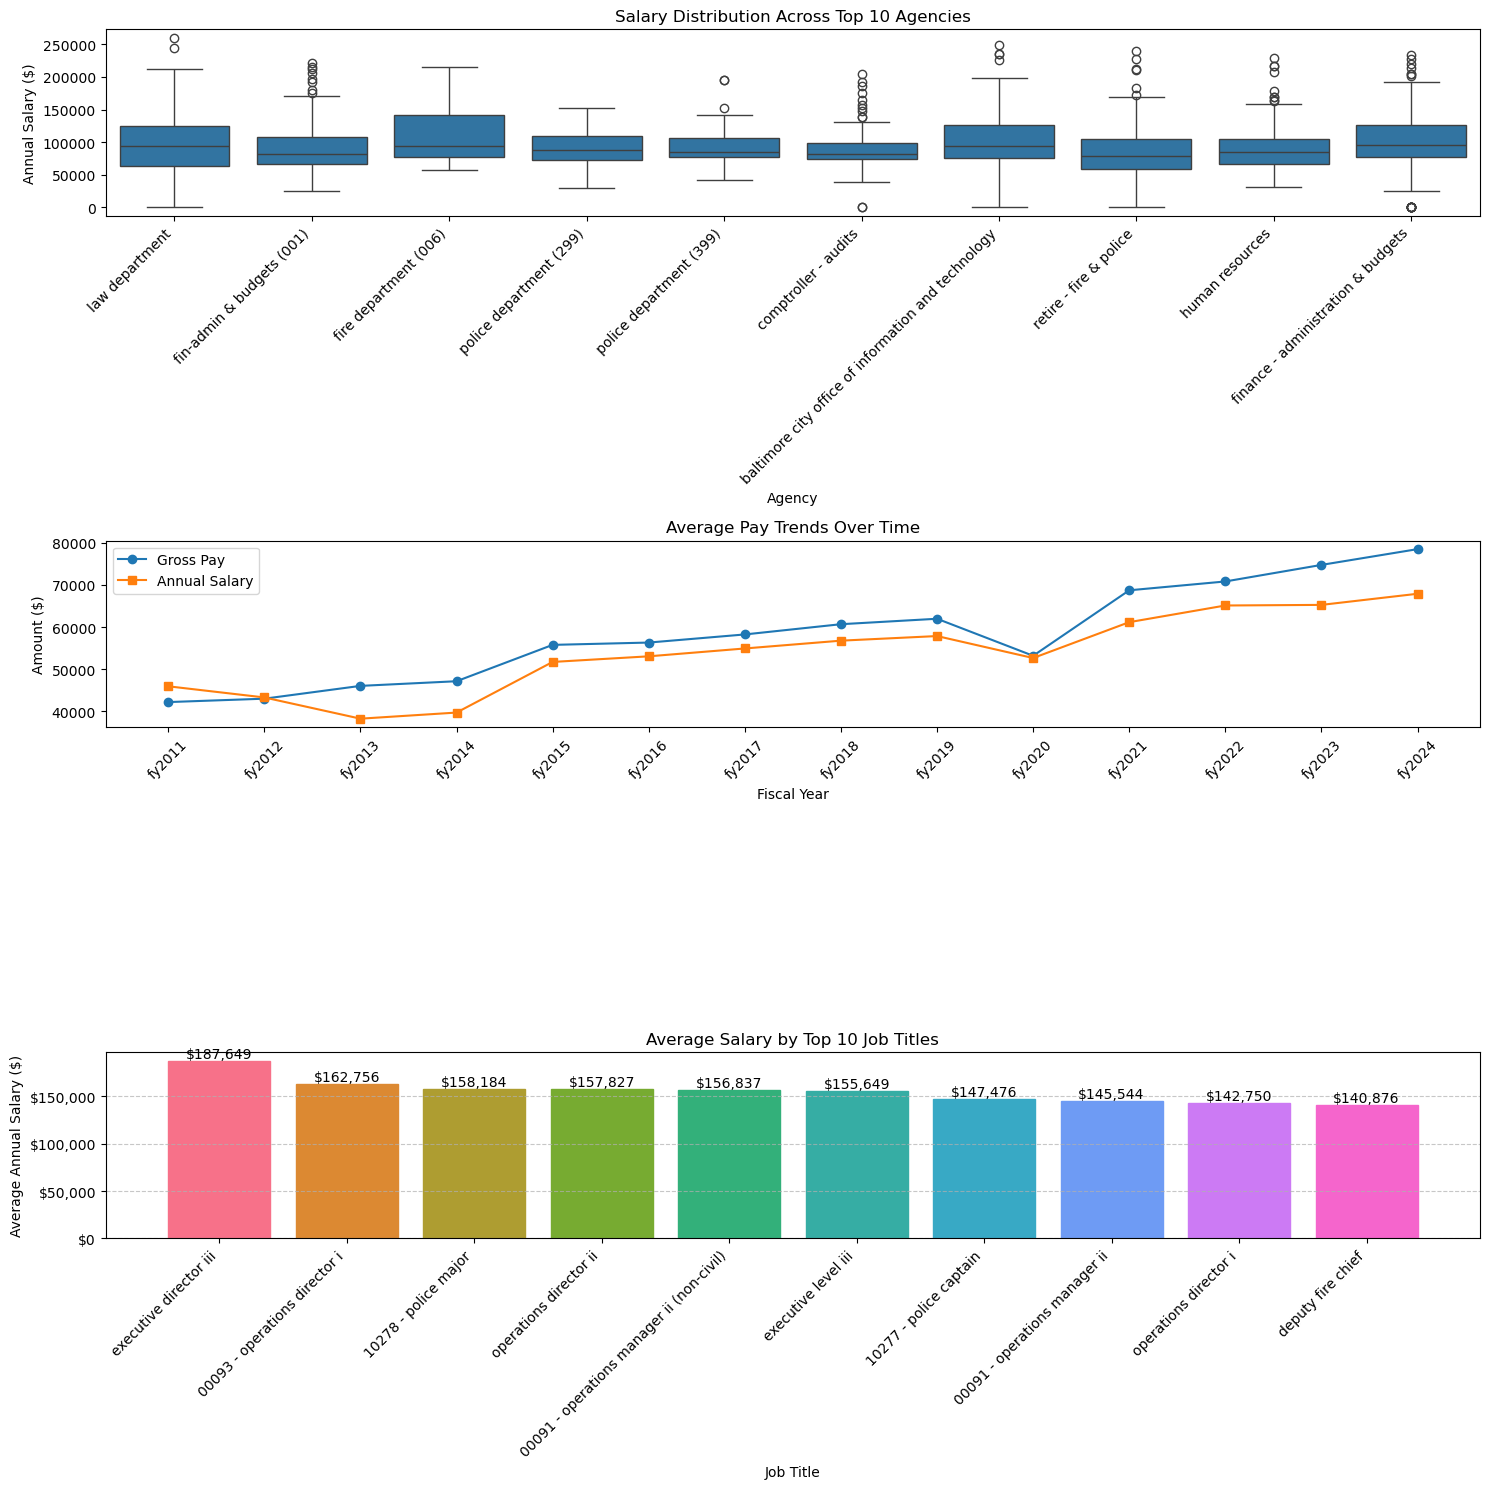

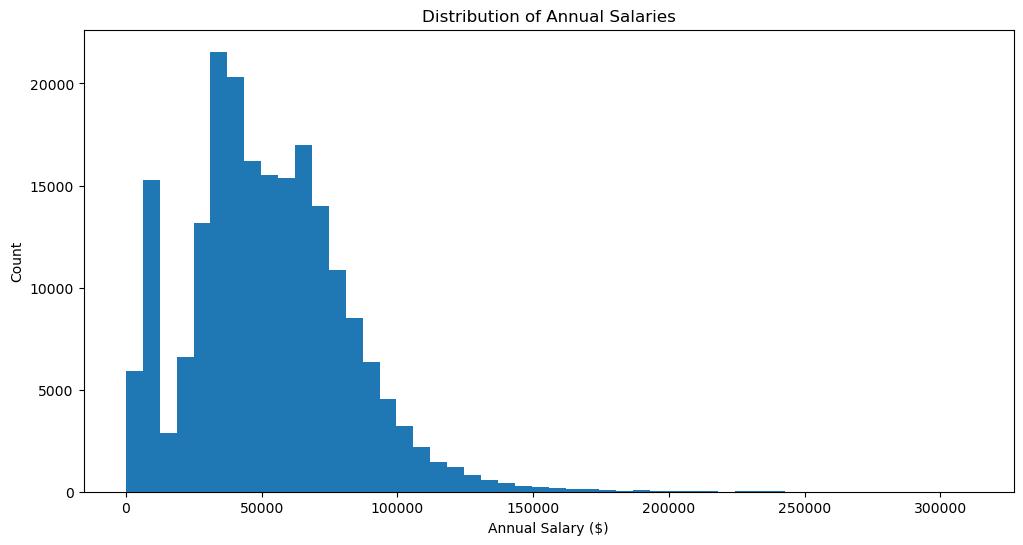


Summary Statistics:
        AnnualSalary   GrossPay
mean        52653.89   57158.85
median      50000.00   55015.73
std         28768.85   36910.31
min             0.00   -3600.00
max        311427.20  373111.19


In [8]:
# Create visualizations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# 1. Agency Salary Box Plot
top_10_agencies = significant_agencies.head(10)['AgencyName'].tolist()
agency_data = data[data['AgencyName'].isin(top_10_agencies)]
sns.boxplot(x='AgencyName', y='AnnualSalary', data=agency_data, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Salary Distribution Across Top 10 Agencies')
ax1.set_xlabel('Agency')
ax1.set_ylabel('Annual Salary ($)')

# 2. Salary Trends Over Time
ax2.plot(yearly_trends['FiscalYear'], yearly_trends['GrossPay'], marker='o', label='Gross Pay')
ax2.plot(yearly_trends['FiscalYear'], yearly_trends['AnnualSalary'], marker='s', label='Annual Salary')
ax2.set_title('Average Pay Trends Over Time')
ax2.set_xlabel('Fiscal Year')
ax2.set_ylabel('Amount ($)')
ax2.legend()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# 3. Job Title Salary Distribution (Enhanced)
top_10_jobs = common_jobs.head(10)
bars = ax3.bar(range(len(top_10_jobs)), top_10_jobs['MeanSalary'])

# Customize the appearance
ax3.set_xticks(range(len(top_10_jobs)))
ax3.set_xticklabels(top_10_jobs['JobTitle'], rotation=45, ha='right')
ax3.set_title('Average Salary by Top 10 Job Titles')
ax3.set_xlabel('Job Title')
ax3.set_ylabel('Average Annual Salary ($)')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=10)

# Add grid for better readability
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Use different colors for each bar
colors = sns.color_palette("husl", len(top_10_jobs))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Format y-axis with comma separator for thousands
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Additional Analysis: Distribution of Salaries
plt.figure(figsize=(12, 6))
plt.hist(data['AnnualSalary'], bins=50)
plt.title('Distribution of Annual Salaries')
plt.xlabel('Annual Salary ($)')
plt.ylabel('Count')
plt.show()

# Calculate summary statistics
summary_stats = data.agg({
    'AnnualSalary': ['mean', 'median', 'std', 'min', 'max'],
    'GrossPay': ['mean', 'median', 'std', 'min', 'max']
}).round(2)

print("\nSummary Statistics:")
print(summary_stats)